In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
# Load data from CSV file
data = pd.read_csv('creditcard.csv')

# Separate features (X) and labels (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# split the data into fraud and non-fraud
X_fraud = X[y == 1]
X_non_fraud = X[y == 0]

2024-09-01 16:40:05.047809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 16:40:05.538205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 16:40:06.790012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h3> I am splitting the non fraud data into 2/3rd part of training and 1/3rd non_fraud + fraud data as validation dataset. </h3>
<h3> I am using the training data to train the model and validation data to validate the model(for calculating the threshold value) </h3>

In [2]:
# split the data into training and validation
X_non_fraud_train, X_non_fraud_val = train_test_split(X_non_fraud, test_size=0.33)
print(X_non_fraud_train.shape, X_non_fraud_val.shape)

# split the X_fraud_train into training and testing 10% of the data
X_non_fraud_train1, X_non_fraud_test1 = train_test_split(X_non_fraud_train, test_size=0.1)

#y-NON_FRAUD_test
y_non_fraud_test1 = np.zeros(X_non_fraud_test1.shape[0])

# combine the X_non_fraud_val and X_fraud into X_val and y_val
X_val = np.concatenate((X_non_fraud_val, X_fraud))
y_val = np.concatenate((np.zeros(X_non_fraud_val.shape[0]), np.ones(X_fraud.shape[0])))

print(X_val.shape)

(190491, 30) (93824, 30)
(94316, 30)


<h4>Model declared here: </h4>

In [3]:

# Define the encoder architecture
encoder = Sequential([
    Dense(10, activation='relu', input_shape=(X_non_fraud_train1.shape[1],)), # matrix shape is 10x30
    Dense(10, activation='relu')
])

# Define the decoder architecture
decoder = Sequential([
    Dense(10, activation='relu', input_shape=(10,)),
    Dense(X_non_fraud_train1.shape[1], activation='linear')
])

# Combine encoder and decoder into an autoencoder
input_layer = Input(shape=(X_non_fraud_train1.shape[1],))
encoded = encoder(input_layer)
decoded = decoder(encoded)

/home/teja/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-01 16:40:13.040482: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [4]:
# include encoder and decoder in autoencoder
autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mse')  # Mean squared error for reconstruction loss

# Train the autoencoder
autoencoder.fit(X_non_fraud_train1, X_non_fraud_train1, epochs=10, batch_size=64, shuffle=True, validation_data=(X_val, X_val)) 


Epoch 1/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 3s 924us/step - loss: 0.0277 - val_loss: 0.0016
Epoch 2/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 765us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 758us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 768us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 796us/step - loss: 9.9253e-04 - val_loss: 0.0011
Epoch 9/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 789us/step - loss: 9.7934e-04 - val_loss: 0.0011
Epoch 10/10
2679/2679 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - loss: 9.7485e-04 - val_loss: 0.0011


2948/2948 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step


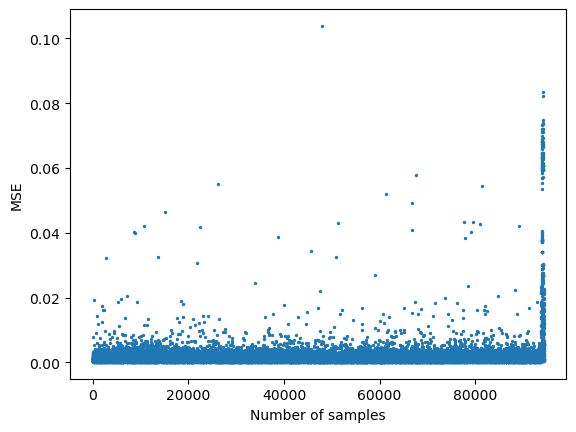

In [5]:
from sklearn.metrics import f1_score, precision_score, accuracy_score
import matplotlib.pyplot as plt


# Calculate the MSE for the validation set
reconstructed_X_val = autoencoder.predict(X_val)
mse_val = np.mean(np.square(X_val - reconstructed_X_val), axis=1)

# scatter the Number of samples(x_axis) vs MSE(y_axis), keep the scatter point size small
plt.scatter(range(X_val.shape[0]), mse_val, s=2)
plt.xlabel('Number of samples')

plt.ylabel('MSE')
plt.show()


<h4> The above plot indicates that the data which is fraud has greater loss than the data which is not fraud. (which is at the end of the graph, I have concatenated the fraud data at the end of X_val) </h4>

<h3> Finding the threshold using percentile method </h3>

In [9]:
import numpy as np

# import f1score, precision_score from sklearn
from sklearn.metrics import f1_score, precision_score, accuracy_score

y_pred = autoencoder.predict(X_val)
print(y_pred.shape)
mse = np.mean(np.square(X_val - y_pred), axis=1) # Mean squared error is the differ
print(mse)
threshold = np.percentile(mse, 95)
print(threshold)


2948/2948 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step
(94316, 30)
[0.00042261 0.00102383 0.00050741 ... 0.00288237 0.00608133 0.00077899]
0.0023969233405716894


In [8]:
from sklearn.metrics import classification_report

y_predicted = mse > threshold 
print(y_predicted.shape)
print(classification_report(y_val, y_predicted))

(94316,)
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98     93824
         1.0       0.09      0.88      0.17       492

    accuracy                           0.95     94316
   macro avg       0.55      0.92      0.57     94316
weighted avg       0.99      0.95      0.97     94316



# VAE part

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# define VAE model

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar
    
    def loss(self, x, x_hat, mu, logvar):
        recon_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div
    

In [8]:
from tqdm import tqdm

# Define the model, optimizer, and other parameters
X_train = X_non_fraud_train1
input_dim = X_train.shape[1]
hidden_dim = 16
latent_dim = 2
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define training parameters
n_epochs = 10
batch_size = 128

# Training loop with tqdm
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = len(X_train) // batch_size
    
    # Create a tqdm progress bar
    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{n_epochs}', unit='batch') as pbar:
        for i in range(0, len(X_train), batch_size):
            x = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
            x_hat, mu, logvar = model(x)
            loss = model.loss(x, x_hat, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)
        
    # Print average loss for the epoch
    avg_loss = epoch_loss / num_batches
    print(f'Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}')


Epoch 1/10: 1340batch [00:05, 224.74batch/s, loss=6.85]                        


Epoch 1/10, Average Loss: 67.1153


Epoch 2/10: 1340batch [00:05, 235.38batch/s, loss=6.72]                       


Epoch 2/10, Average Loss: 16.0102


Epoch 3/10: 1340batch [00:05, 225.67batch/s, loss=6.66]                       


Epoch 3/10, Average Loss: 15.9289


Epoch 4/10: 1340batch [00:06, 223.17batch/s, loss=6.69]                       


Epoch 4/10, Average Loss: 15.9187


Epoch 5/10: 1340batch [00:05, 259.71batch/s, loss=6.69]                       


Epoch 5/10, Average Loss: 15.9167


Epoch 6/10: 1340batch [00:05, 234.42batch/s, loss=6.69]                       


Epoch 6/10, Average Loss: 15.9154


Epoch 7/10: 1340batch [00:05, 262.61batch/s, loss=6.68]                       


Epoch 7/10, Average Loss: 15.9157


Epoch 8/10: 1340batch [00:04, 280.75batch/s, loss=6.68]                       


Epoch 8/10, Average Loss: 15.9116


Epoch 9/10: 1340batch [00:05, 262.74batch/s, loss=6.69]                       


Epoch 9/10, Average Loss: 15.9108


Epoch 10/10: 1340batch [00:05, 236.77batch/s, loss=6.71]                       

Epoch 10/10, Average Loss: 15.9064


<h3> Finding the threshold using percentile method </h3>

In [14]:
import numpy as np

# import f1score, precision_score from sklearn
from sklearn.metrics import f1_score, precision_score, accuracy_score

# convert the X_val to tensor
X_val = torch.tensor(X_val, dtype=torch.float32)

y_pred,_,_ = model(X_val)
# print(y_pred.shape)
mse= np.mean(np.square(X_val.detach().numpy() - y_pred.detach().numpy()), axis=1)

# mse = np.mean(np.square(X_val - y_pred), axis=1)

threshold = np.percentile(mse, 95)
print(threshold)


0.00911129079759121


/tmp/ipykernel_51728/4081340268.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


In [15]:
from sklearn.metrics import classification_report

y_predicted = mse > threshold
print(classification_report(y_val, y_predicted))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98     93824
         1.0       0.07      0.68      0.13       492

    accuracy                           0.95     94316
   macro avg       0.53      0.82      0.55     94316
weighted avg       0.99      0.95      0.97     94316



<h2> Results: </h2>
<h4> f1 score for Autoencoders is 0.97, precision is 1, accuracy is 0.95. </h4>
<h4> f1 score for VAE is 0.98, precision is 0.16, accuracy is 0.95. </h4>
<h4> VAE has better f1 score than Autoencoders. </h4>